<img src="https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/media/logo/newebac_logo_black_half.png" alt="ebac-logo">

---

# **Módulo** | Análise de Dados: Análise Exploratória de Dados de Logística III
[Ivan Trigueiro](https://www.linkedin.com/in/ivantrigueiro/)

---

# **Tópicos**

<ol type="1">
  <li>Manipulação;</li>
  <li>Visualização;</li>
  <li>Storytelling.</li>
</ol>


---

# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Uma empresa de entregas que opera em três regiões do Distrito Federal: df-0, df-1 e df-2. Possui uma frota de carros distribuídos igualmente entre as três regiões. A empresa quer entender como alocar os carros de forma mais eficiente para atender à demanda de entregas em cada região. Para isso, a empresa coletou dados de suas entregas realizadas em cada região durante um determinado tempo.

## 2\. Pacotes e bibliotecas

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import json
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import geopandas

## 3\. Exploração de dados

In [3]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [4]:
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Dados brutos transformados em um dataframe Pandas
deliveries_df = pd.DataFrame(data)

# Normalizando a coluna "origin"
hub_origin_df = pd.json_normalize(deliveries_df["origin"])

# Merge do hub_origin com o deliveries
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Removendo a coluna "origin" ja que as partes que compoem essa coluna ja esta no df
deliveries_df = deliveries_df.drop("origin", axis=1)

# Reorganizando as colunas para ficar parecido com o df original
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]

# Deixando as colunas mais legiveis
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


In [5]:
# Agora vamos lidar com a coluna "deliveries"
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")

# Pegando cada elemento de size, point->lng e point->lat renomeando para algo
# mais legivel e concatenando as colunas num df normalizado
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

# Fazendo o merge do df normalizado e o deliveries_df
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df.reset_index(inplace=True, drop=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055


## 4\. Manipulação

In [6]:
# Obtendo apenas as regioes e suas respectivas Lat e Lon
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [7]:
# Configurando o nominatim
geolocator = Nominatim(user_agent="ivan_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [8]:
# Obtendo as coordenadas
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)

# Normalizando os dados
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

# Pegando colunas interessantes para analises e renomeando para se adequar ao nosso df
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)

# Fazendo o merge com o hub_df e depois com o deliveries_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]

In [9]:
# Os dados tratados acima geram um arquivo csv, que demorariam 7 dias devido ao limite do Nomatim
# de 1 req por seg. Entao vamos pegar o arquivo ja tratado, disponibilizado pelo professor.
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [10]:
# Fazendo o merge dos dados com o deliveries_df
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)

## 5\. Visualização

Agora vamos visualizar os dados em um mapa do Distrito Federal. Comecando pelo download do mapa no site Oficial do IBGE.

In [11]:
# !wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
# !unzip -q distrito-federal.zip -d ./maps
# !cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
# !cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

replace ./maps/ASB_Cemiterio_A.dbf? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Criando um novo dataframe com o geopandas, existe uma nota coluna geometry com a localizacao da regiao.

In [12]:
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Fazemos o mesmo acima mas para todos os locais de entrega no deliveries_df

In [13]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


Agora vamos ver o resultado.

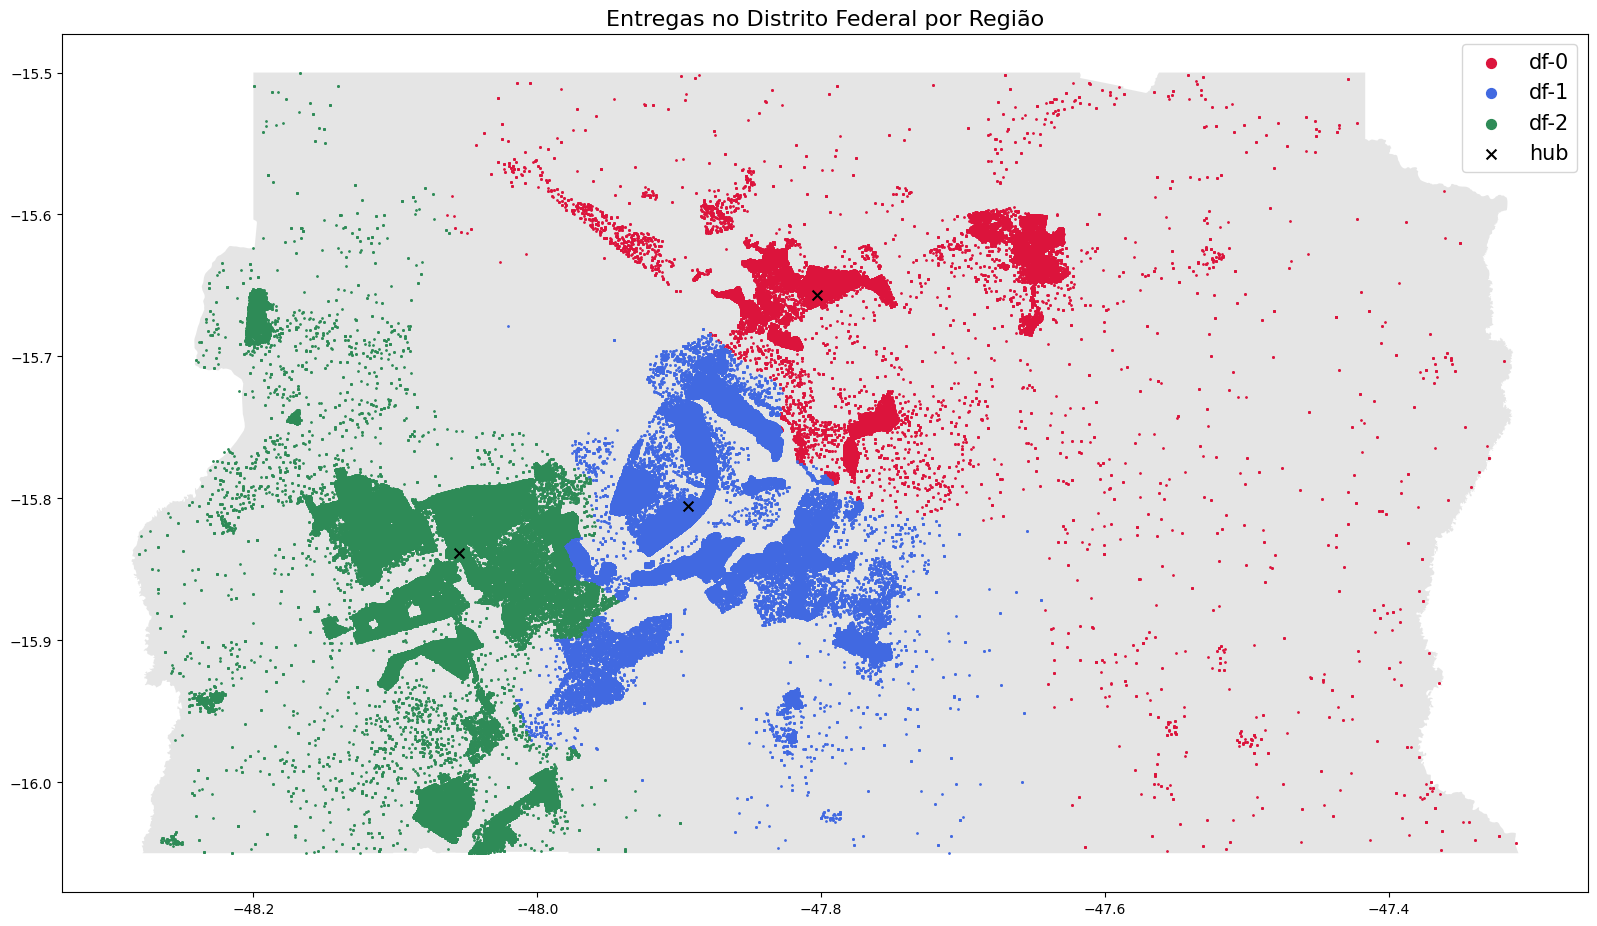

In [14]:
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="silver")

geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="crimson", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="royalblue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

geo_hub_df.plot(ax=ax, markersize=50, marker="x", color="black", label="hub")

plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])


* Os hubs de entrega estão estrategicamente localizados para atender a três regiões distintas, o que pode otimizar o tempo e os custos de entrega.
* A distribuição das entregas parece bem distribuída, indicando uma cobertura eficiente.
* Há uma concentração significativa de entregas em certas áreas, o que pode indicar uma demanda mais alta e potencialmente sobrecarregar os recursos de entrega.
* Existem áreas com menos entregas, o que pode indicar oportunidades perdidas ou a necessidade de avaliar a eficiência da rota e do serviço.

## Agora vamos avaliar a densidade da frota de carros.

In [43]:
total_delivery_size_df0 = geo_deliveries_df[geo_deliveries_df["region"] == "df-0"]["delivery_size"].sum()
vehicles_df0 = math.ceil(total_delivery_size_df0/180)
total_delivery_size_df1 = geo_deliveries_df[geo_deliveries_df["region"] == "df-1"]["delivery_size"].sum()
vehicles_df1 = math.ceil(total_delivery_size_df1/180)
total_delivery_size_df2 = geo_deliveries_df[geo_deliveries_df["region"] == "df-2"]["delivery_size"].sum()
vehicles_df2 = math.ceil(total_delivery_size_df2/180)

Aqui calculamos a quantidade de carros em porcentagem que cada regiao necessita.

In [46]:
regions = ["df-0", "df-1", "df-2"]
vehicles = [vehicles_df0, vehicles_df1, vehicles_df2]
total = sum(vehicles)
percentages = [vehicle / total * 100 for vehicle in vehicles]

Entao temos o grafico abaixo.

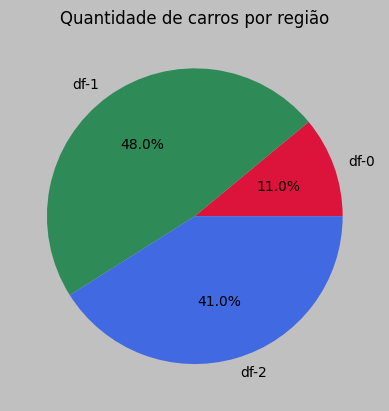

In [60]:
plt.figure(facecolor="silver")
plt.pie(percentages, labels=regions, colors=["crimson", "seagreen", "royalblue"], autopct="%1.1f%%")
plt.title("Quantidade de carros por região")
plt.show()

* O gráfico mostra que a região df-1 tem a maior densidade de entregas, com 48% dos carros sendo necessários lá, seguido por df-2 com 41%, e df-0 com apenas 11%. Isso indica que há um desbalanceamento entre a demanda e a oferta de carros em cada região, o que pode afetar a eficiência e a satisfação dos clientes.
* A empresa pode considerar realocar mais veículos para as regiões df-1 e df-2 para atender à demanda mais alta. No entanto, é essencial garantir que a realocação não afete negativamente o tempo de entrega na região df-0, que pode ter uma demanda mais variável ou sazonal.
* A empresa deve monitorar continuamente o desempenho dos carros em cada região, usando indicadores como o número de entregas, o tempo médio de entrega, a taxa de sucesso, a satisfação dos clientes, etc. A empresa deve ajustar a alocação dos carros de acordo com as mudanças na demanda, na oferta, nas condições do mercado, etc., buscando sempre otimizar a eficácia e a eficiência do serviço.